**Étape 1 : Préparation des données**



** Installation des bibliothèques**

In [1]:
# Installer les bibliothèques principales
!pip install transformers
!pip install datasets
!pip install torch torchvision
!pip install scikit-learn
!pip install arabic_reshaper
!pip install bidi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement bidi (from versions: none)
ERROR: No matching distribution found for bidi


**Importation et Téléchargement des données**

In [3]:
from google.colab import files
uploaded = files.upload()


Saving SANAD_SUBSET.zip to SANAD_SUBSET.zip


In [4]:
!unzip SANAD_SUBSET.zip -d dataset


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: dataset/khaleej/Train/Culture/00f577f59ac9.txt  
  inflating: dataset/khaleej/Train/Culture/0f8c6c1fbfb1.txt  
  inflating: dataset/khaleej/Train/Culture/2279dc2b4ef0.txt  
  inflating: dataset/khaleej/Train/Culture/34c8bdda56b8.txt  
  inflating: dataset/khaleej/Train/Culture/2a1dd79f213f.txt  
  inflating: dataset/khaleej/Train/Culture/06e7a2f41572.txt  
  inflating: dataset/khaleej/Train/Culture/2480530a7c95.txt  
  inflating: dataset/khaleej/Train/Culture/12ed0be04318.txt  
  inflating: dataset/khaleej/Train/Culture/37cee96d9287.txt  
  inflating: dataset/khaleej/Train/Culture/2a4af8ef77b8.txt  
  inflating: dataset/khaleej/Train/Culture/14bea0b04409.txt  
  inflating: dataset/khaleej/Train/Culture/2af68aa24de2.txt  
  inflating: dataset/khaleej/Train/Culture/23c87582fe37.txt  
  inflating: dataset/khaleej/Train/Culture/279386f5a587.txt  
  inflating: dataset/khaleej/Train/Culture/1789a240a0a

**Lister les fichiers et dossiers**

In [5]:
import os

# Lister les fichiers et dossiers dans le répertoire
dataset_path = "dataset"
for root, dirs, files in os.walk(dataset_path):
    print(f"Dans le dossier : {root}")
    for file in files[:5]:  # Limiter à 5 fichiers pour éviter une longue liste
        print(f"  - {file}")
    print("\n")


Dans le dossier : dataset


Dans le dossier : dataset/khaleej


Dans le dossier : dataset/khaleej/Train


Dans le dossier : dataset/khaleej/Train/Tech
  - 9dd0d3534468.txt
  - 082da6116f9f.txt
  - bb2722f5fde6.txt
  - ea884c4d5add.txt
  - 35ee9eb0de94.txt


Dans le dossier : dataset/khaleej/Train/Medical
  - 350e6dd97b50.txt
  - 49e7d607d7a0.txt
  - 615b31589c58.txt
  - 6c7ac96f020b.txt
  - 2e63de64afa9.txt


Dans le dossier : dataset/khaleej/Train/Culture
  - 189f106532ea.txt
  - 20c9b42cdb6a.txt
  - 386c4508892c.txt
  - 2bfb75725376.txt
  - 333b0aea4e0c.txt


Dans le dossier : dataset/khaleej/Train/Politics
  - 044ef5863901.txt
  - 07321b71ed0e.txt
  - 059a3ee503b0.txt
  - 059bed64beec.txt
  - 0017949f3383.txt


Dans le dossier : dataset/khaleej/Train/Finance
  - 21d64e020727.txt
  - 272bcf97d575.txt
  - 218be17aaccc.txt
  - 07f8bcd84ed0.txt
  - 318cabd9341a.txt


Dans le dossier : dataset/khaleej/Train/Religion
  - 50c1a0468878.txt
  - 78157faf432c.txt
  - 2d4e76be4d05.txt
  - 5ea6d

=> Analyse de la structure
Organisation des données :

Les fichiers sont organisés en trois dossiers principaux : arabiya, akhbarona, et khaleej.
Chaque dossier contient deux sous-dossiers : Train et Test.
Ces sous-dossiers sont divisés en catégories (e.g., Medical, Finance, Politics, etc.).
Chaque catégorie contient plusieurs fichiers .txt ou .html.

Observation :

Les fichiers contiennent du texte brut ou du HTML.
Les noms des fichiers semblent aléatoires ou basés sur des identifiants.


**Charger et préparer les données**

In [6]:
import os
from bs4 import BeautifulSoup

# Fonction pour charger les fichiers et extraire le texte et la catégorie
def load_articles(base_path):
    texts = []
    labels = []

    # Parcourir les dossiers (chaque dossier correspond à une catégorie)
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                try:
                    with open(file_path, "r", encoding="utf-8") as f:
                        # Si le fichier est en HTML, extraire le texte principal
                        if file_name.endswith(".html"):
                            soup = BeautifulSoup(f.read(), "html.parser")
                            text = soup.get_text()
                        else:
                            text = f.read()

                        texts.append(text.strip())  # Ajouter le texte nettoyé
                        labels.append(category)  # Ajouter la catégorie (label)
                except Exception as e:
                    print(f"Erreur avec le fichier {file_path}: {e}")
    return texts, labels

# Charger les données d'entraînement et de test
train_texts, train_labels = load_articles("dataset/arabiya/Train")
test_texts, test_labels = load_articles("dataset/arabiya/Test")


**Netoyage des textes**

In [7]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Supprimer les URLs
    text = re.sub(r"[^\w\s]", "", text)  # Supprimer les caractères spéciaux
    text = re.sub(r"\s+", " ", text).strip()  # Supprimer les espaces multiples
    return text

# Appliquer le nettoyage aux données
train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]


**Encodage des labels**

Transformez les catégories (labels) en valeurs numériques pour qu'elles soient compatibles avec un modèle de classification.



In [8]:
from sklearn.preprocessing import LabelEncoder

# Encoder les labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Afficher les classes encodées
print("Classes encodées :", label_encoder.classes_)


Classes encodées : ['Finance' 'Medical' 'Politics' 'Sports' 'Tech']


**Étape 2 : Tokenisation et Préparation du modèle**

**Préparer les données pour BERT**

Utilisez Hugging Face Transformers pour tokenizer les articles et les préparer à l'entraînement.

Tokenisation

In [9]:
from transformers import AutoTokenizer

# Charger le tokenizer pré-entraîné pour l'arabe
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

# Tokenizer les données
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Créer un Dataset PyTorch

In [10]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)


**Fine-tuning de BERT**

Charger le modèle

In [11]:
from transformers import AutoModelForSequenceClassification

# Charger le modèle BERT avec le bon nombre de labels
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2",
    num_labels=len(label_encoder.classes_)
)


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configurer l'entraînement

Utilisez le Trainer de Hugging Face pour entraîner le modèle.

In [12]:
# Étape 2 : Tokenisation et Préparation du modèle

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le tokenizer pré-entraîné pour l'arabe
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

# Tokenizer les données
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Charger le modèle pré-entraîné BERT pour la classification
model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2",
    num_labels=len(label_encoder.classes_)
)

# Afficher la structure du modèle chargé pour inspection
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Étape 3 : Entraînement du modèle**

In [13]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm


In [14]:
batch_size = 16  # Vous pouvez ajuster en fonction de la mémoire disponible

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [15]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
epochs = 3

for epoch in range(epochs):
    print(f"Époque {epoch + 1}/{epochs}")
    model.train()  # Met le modèle en mode entraînement
    total_train_loss = 0

    # Entraînement
    for batch in tqdm(train_loader, desc="Entraînement"):
        # Déplacer les données sur l'appareil (GPU/CPU)
        batch = {key: val.to(device) for key, val in batch.items()}

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calcul des prédictions et de la perte
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Perte moyenne sur l'entraînement : {avg_train_loss:.4f}")

    # Validation après chaque époque
    model.eval()  # Met le modèle en mode évaluation
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            # Déplacer les données sur l'appareil
            batch = {key: val.to(device) for key, val in batch.items()}

            # Calcul des prédictions et de la perte
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Calcul des prédictions correctes
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = correct / total
    print(f"Perte moyenne sur la validation : {avg_val_loss:.4f}")
    print(f"Exactitude (Accuracy) : {accuracy:.4f}")


Époque 1/3


Entraînement: 100%|██████████| 1041/1041 [26:08<00:00,  1.51s/it]


Perte moyenne sur l'entraînement : 0.1309


Validation: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]


Perte moyenne sur la validation : 0.0642
Exactitude (Accuracy) : 0.9811
Époque 2/3


Entraînement: 100%|██████████| 1041/1041 [26:09<00:00,  1.51s/it]


Perte moyenne sur l'entraînement : 0.0509


Validation: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]


Perte moyenne sur la validation : 0.0406
Exactitude (Accuracy) : 0.9870
Époque 3/3


Entraînement: 100%|██████████| 1041/1041 [26:09<00:00,  1.51s/it]


Perte moyenne sur l'entraînement : 0.0305


Validation: 100%|██████████| 116/116 [00:55<00:00,  2.10it/s]

Perte moyenne sur la validation : 0.0324
Exactitude (Accuracy) : 0.9914


**Etape 4:Évaluation et Résultats**
Après avoir entraîné mon modèle, je vais évaluer ses performances sur l’ensemble de test en utilisant la précision (accuracy), le rappel (recall), la précision (precision), et le F1-score.

In [18]:
def evaluate_model(model, data_loader):
    model.eval()  # Mettre le modèle en mode évaluation
    predictions = []
    true_labels = []

    with torch.no_grad():  # Pas de calcul des gradients
        for batch in data_loader:
            # Déplacer les données sur le GPU (si disponible)
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)

            # Récupérer les prédictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())  # Passer les prédictions sur CPU
            true_labels.extend(batch["labels"].cpu().numpy())  # Labels vrais sur CPU

    return predictions, true_labels


In [19]:
print("Évaluation sur le jeu de test en cours...")
test_predictions, test_labels = evaluate_model(model, test_loader)


Évaluation sur le jeu de test en cours...


In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Afficher le rapport de classification
print("Rapport de Classification :\n")
print(classification_report(test_labels, test_predictions, target_names=label_encoder.classes_))

# Calculer l'accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy : {accuracy:.4f}")


Rapport de Classification :

              precision    recall  f1-score   support

     Finance       0.98      0.98      0.98       370
     Medical       1.00      1.00      1.00       370
    Politics       1.00      1.00      1.00       370
      Sports       0.99      1.00      0.99       370
        Tech       0.99      0.98      0.98       370

    accuracy                           0.99      1850
   macro avg       0.99      0.99      0.99      1850
weighted avg       0.99      0.99      0.99      1850

Accuracy : 0.9914


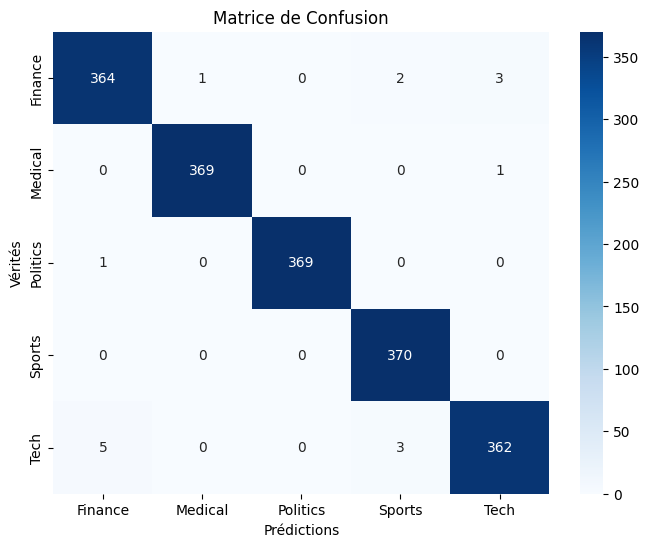

In [21]:
# Créer la matrice de confusion
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Afficher la matrice de confusion sous forme graphique
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()


Le modèle atteint une performance remarquable avec une **accuracy globale de 99.14%** et des scores de précision, rappel, et F1-score proches de **1.00** pour toutes les classes. Cela montre que le modèle classifie correctement presque toutes les instances, avec une performance équilibrée sur toutes les classes, comme en témoignent les scores macro et weighted averages. La matrice de confusion met en évidence une gestion quasi-parfaite des classes "Medical", "Politics", et "Sports", tandis que quelques erreurs subsistent entre "Finance" et "Tech", probablement dues à des similarités contextuelles dans les données.

Malgré ces rares erreurs, le modèle est robuste et efficace pour la tâche de classification. Pour réduire davantage ces confusions, notamment entre "Finance" et "Tech", on pourrait envisager d’enrichir les données pour ces classes ou d’ajuster les hyperparamètres.

**Etape 5 : Testing**

In [25]:
# Function to predict the class of a given text
def test_model_on_examples(model, tokenizer, label_encoder, examples):
    model.eval()  # Set the model to evaluation mode
    results = []

    for text in examples:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():  # Disable gradient calculation for evaluation
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).cpu().numpy()[0]

        # Decode the predicted class to its label
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]
        results.append((text, predicted_label))

    return results

# Example inputs to test the model
test_examples = [
    "أرباح البنوك ارتفعت هذا العام بشكل ملحوظ.",  # Expected: Finance
    "التكنولوجيا الحديثة تغير طريقة حياتنا اليومية.",  # Expected: Tech
    "الرياضة تساعد في تحسين الصحة العقلية والجسدية.",  # Expected: Sports
    "السياسة المحلية تؤثر على حياتنا اليومية.",  # Expected: Politics
    "تحدث الطبيب عن أهمية التشخيص المبكر للمرض.",  # Expected: Medical
]

# Test the model on the examples
print("Testing the model on sample inputs:\n")
results = test_model_on_examples(model, tokenizer, label_encoder, test_examples)

# Print the results
for i, (text, label) in enumerate(results):
    print(f"Example {i + 1}: {text}")
    print(f"Predicted Label: {label}\n")


Testing the model on sample inputs:

Example 1: أرباح البنوك ارتفعت هذا العام بشكل ملحوظ.
Predicted Label: Finance

Example 2: التكنولوجيا الحديثة تغير طريقة حياتنا اليومية.
Predicted Label: Tech

Example 3: الرياضة تساعد في تحسين الصحة العقلية والجسدية.
Predicted Label: Sports

Example 4: السياسة المحلية تؤثر على حياتنا اليومية.
Predicted Label: Medical

Example 5: تحدث الطبيب عن أهمية التشخيص المبكر للمرض.
Predicted Label: Finance



In [26]:
def batch_test_model(model, tokenizer, label_encoder, examples):
    model.eval()  # Set the model to evaluation mode
    batch_size = 8  # Process multiple examples in one go
    results = []

    # Split examples into batches
    for i in range(0, len(examples), batch_size):
        batch = examples[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():  # Disable gradient calculation for evaluation
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()

        # Decode predicted classes to labels
        decoded_labels = label_encoder.inverse_transform(predicted_classes)
        results.extend(zip(batch, decoded_labels))

    return results

# Batch of inputs to test the model
test_sentences = [
    "تحدث الرئيس عن آخر التطورات السياسية.",  # Expected: Politics
    "أطلقت الشركة منتجاً تقنياً جديداً لتحسين الإنتاجية.",  # Expected: Tech
    "الطبيب أكد على أهمية النوم الكافي لصحة جيدة.",  # Expected: Medical
    "استعرضت الأسواق المالية مكاسب كبيرة هذا الأسبوع.",  # Expected: Finance
    "حقق الفريق فوزاً كبيراً في مباراة الأمس.",  # Expected: Sports
    "العملة الرقمية سجلت ارتفاعاً غير مسبوق.",  # Expected: Finance
    "الرياضة تعتبر أساسية للحفاظ على صحة القلب.",  # Expected: Sports
    "الحكومة أعلنت عن خطة جديدة لدعم الاقتصاد.",  # Expected: Politics
    "تم اكتشاف علاج جديد يساعد في تقليل آلام المفاصل.",  # Expected: Medical
    "التكنولوجيا الحديثة تلعب دوراً أساسياً في التعليم.",  # Expected: Tech
]

# Test the model with the batch of sentences
print("Testing the model on a batch of sentences:\n")
batch_results = batch_test_model(model, tokenizer, label_encoder, test_sentences)

# Print the results
for i, (text, label) in enumerate(batch_results):
    print(f"Sentence {i + 1}: {text}")
    print(f"Predicted Label: {label}\n")


Testing the model on a batch of sentences:

Sentence 1: تحدث الرئيس عن آخر التطورات السياسية.
Predicted Label: Politics

Sentence 2: أطلقت الشركة منتجاً تقنياً جديداً لتحسين الإنتاجية.
Predicted Label: Finance

Sentence 3: الطبيب أكد على أهمية النوم الكافي لصحة جيدة.
Predicted Label: Sports

Sentence 4: استعرضت الأسواق المالية مكاسب كبيرة هذا الأسبوع.
Predicted Label: Finance

Sentence 5: حقق الفريق فوزاً كبيراً في مباراة الأمس.
Predicted Label: Sports

Sentence 6: العملة الرقمية سجلت ارتفاعاً غير مسبوق.
Predicted Label: Finance

Sentence 7: الرياضة تعتبر أساسية للحفاظ على صحة القلب.
Predicted Label: Sports

Sentence 8: الحكومة أعلنت عن خطة جديدة لدعم الاقتصاد.
Predicted Label: Finance

Sentence 9: تم اكتشاف علاج جديد يساعد في تقليل آلام المفاصل.
Predicted Label: Medical

Sentence 10: التكنولوجيا الحديثة تلعب دوراً أساسياً في التعليم.
Predicted Label: Finance




Classification Report:
              precision    recall  f1-score   support

     Finance       0.98      0.98      0.98       370
     Medical       1.00      1.00      1.00       370
    Politics       1.00      1.00      1.00       370
      Sports       0.99      1.00      0.99       370
        Tech       0.99      0.98      0.98       370

    accuracy                           0.99      1850
   macro avg       0.99      0.99      0.99      1850
weighted avg       0.99      0.99      0.99      1850

Accuracy: 0.9914


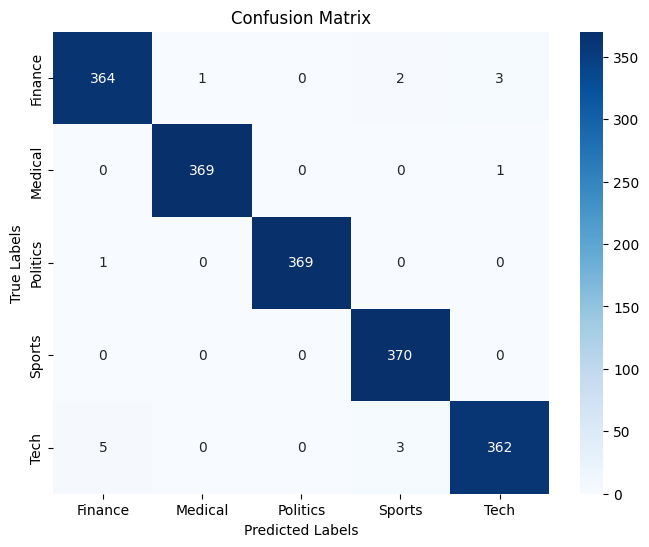

In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to evaluate the model
def evaluate_test_set(model, tokenizer, label_encoder, test_texts, test_labels):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = test_labels

    # Process the test set
    for text in test_texts:
        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).cpu().numpy()[0]
            predictions.append(predicted_class)

    # Decode labels for better interpretation
    predicted_labels = label_encoder.inverse_transform(predictions)
    true_labels_decoded = label_encoder.inverse_transform(true_labels)

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels_decoded, predicted_labels, target_names=label_encoder.classes_))

    # Compute Accuracy
    accuracy = accuracy_score(true_labels_decoded, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels_decoded, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the test set
evaluate_test_set(model, tokenizer, label_encoder, test_texts, test_labels)
